# 机器学习策略演示

本notebook演示如何使用机器学习方法构建一个简单的交易策略。主要步骤包括：

1. 数据获取与预处理
2. 简单因子/特征构造
3. 目标变量（下期收益）的定义
4. 训练简单的MLP模型
5. 策略回测
6. 使用Backtrader进行回测

## 0. 导入依赖包

In [3]:
import yfinance as yf
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import os
import talib  # 如果报错找不到ta-lib，需先安装并确认本地编译环境
import sys

from dotenv import load_dotenv, find_dotenv
# Find the .env file in the parent directory
dotenv_path = find_dotenv("../../.env")
# Load it explicitly
load_dotenv(dotenv_path)

# Add the parent directory to the sys.path list
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from data_processing import load_data_year, flatten_yf_columns, standardize_columns
from plotting import plot_results
from strategy.buy_and_hold import BuyAndHoldStrategy
from back_test import run_backtest
import backtrader as bt


# 设置显示选项
pd.set_option('display.float_format', lambda x: '%.4f' % x)
# 绘图风格（可选）
plt.style.use('seaborn-v0_8-bright')
# 设置中文显示
plt.rcParams['font.sans-serif'] = ['PingFang HK']
plt.rcParams['axes.unicode_minus'] = False

## 1. 数据获取与预处理

我们获取TSLA过去5年的日线数据。

In [4]:
# 设定时间范围（从现在往前推5年）
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)

print(f"获取数据时间范围：{start_date.strftime('%Y-%m-%d')} 到 {end_date.strftime('%Y-%m-%d')}")

# 下载特斯拉数据
ticker = 'TSLA'
data = yf.download(ticker, start=start_date, end=end_date)

获取数据时间范围：2020-03-13 到 2025-03-12
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


## 1.2 数据预处理

In [5]:
data = flatten_yf_columns(data)
data = standardize_columns(data)

In [6]:
print(data.info())              # 看看总共有多少行、列，各字段数据类型
print(data.head(10))           # 查看前10行，确认最早日期
print(data.tail(10))           # 查看后10行，确认最晚日期
print(data.index.min())  # DataFrame中最早的日期
print(data.index.max())  # DataFrame中最晚的日期


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1255 entries, 2020-03-13 to 2025-03-11
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   1255 non-null   float64
 1   high    1255 non-null   float64
 2   low     1255 non-null   float64
 3   open    1255 non-null   float64
 4   volume  1255 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 58.8 KB
None
             close    high     low    open     volume
Date                                                 
2020-03-13 36.4413 40.5047 33.4667 39.6667  339604500
2020-03-16 29.6713 32.9913 29.4780 31.3000  307342500
2020-03-17 28.6800 31.4567 26.4000 29.3340  359919000
2020-03-18 24.0813 26.9907 23.3673 25.9333  356793000
2020-03-19 28.5093 30.1333 23.8973 24.9800  452932500
2020-03-20 28.5020 31.8000 28.3860 29.2133  424282500
2020-03-23 28.9527 29.4667 27.3667 28.9067  246817500
2020-03-24 33.6667 34.2460 31.6000 31.8200  343428000
2020-03-25 35.9500 37

## 2. 加入更多技术指标

构建两个简单的因子：
1. 动量因子：过去5日涨跌幅
2. 成交量比值：最近5日均量vs最近10日均量
3. 先举几个常用指标的例子：RSI, MACD, 布林带。

In [7]:
# 复制数据
df = data.copy()

# 动量因子: 过去5日涨跌幅
df['momentum_5'] = df['close'] / df['close'].shift(5) - 1

# 成交量因子: (最近5日平均成交量) / (最近10日平均成交量) - 1
df['vol_ratio'] = (df['volume'].rolling(5).mean()) / (df['volume'].rolling(10).mean()) - 1

# 计算RSI (默认周期14)
df['RSI_14'] = talib.RSI(df['close'], timeperiod=14)

# 布林带
upper, middle, lower = talib.BBANDS(
    df['close'],
    timeperiod=20,
    nbdevup=2,
    nbdevdn=2,
    matype=0
)
df['BB_upper'] = upper
df['BB_middle'] = middle
df['BB_lower'] = lower

# 也可以增加其他指标，比如ATR, CCI等，根据需要添加
df.dropna(inplace=True)  # 丢掉因子无法计算的前几行

factors = ['momentum_5', 'vol_ratio' ,'RSI_14','BB_upper','BB_lower']
# 看看加上技术指标后的DataFrame
print(df[['close'] + factors].tail(5))


              close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                  
2025-03-05 279.1000     -0.0402     0.1253 29.9017  397.3141  261.0209
2025-03-06 263.4500     -0.0656     0.0620 26.9042  393.4019  253.4611
2025-03-07 262.6700     -0.1035     0.0087 26.7602  388.5007  247.1973
2025-03-10 222.1500     -0.2196     0.0368 20.5942  389.9048  231.8462
2025-03-11 230.5800     -0.1524     0.0812 24.4922  388.9695  220.7665


## 3. 目标变量的定义

定义下期1日收益率作为目标变量。

添加目标变量后的数据预览：
             close  momentum_5  vol_ratio  RSI_14  BB_upper  BB_lower
Date                                                                 
2020-04-09 38.2000      0.2608     0.0272 54.1876   39.7858   25.4478
2020-04-13 43.3967      0.3561    -0.0236 61.5239   41.4042   24.5249
2020-04-14 47.3260      0.3751     0.0475 65.9624   44.2006   23.4940
2020-04-15 48.6553      0.3380     0.0749 67.3352   46.7505   22.9416
2020-04-16 49.6807      0.3578     0.1159 68.3941   48.6161   23.6360
2020-04-17 50.2593      0.3157     0.1495 69.0048   50.6157   23.8114
2020-04-20 49.7573      0.1466     0.1144 67.7812   52.1107   24.4419
2020-04-21 45.7813     -0.0326    -0.0262 58.8769   52.6247   25.6108
2020-04-22 48.8073      0.0031    -0.1078 62.8743   53.7665   25.9830
2020-04-23 47.0420     -0.0531    -0.1902 59.2555   54.5341   26.3247


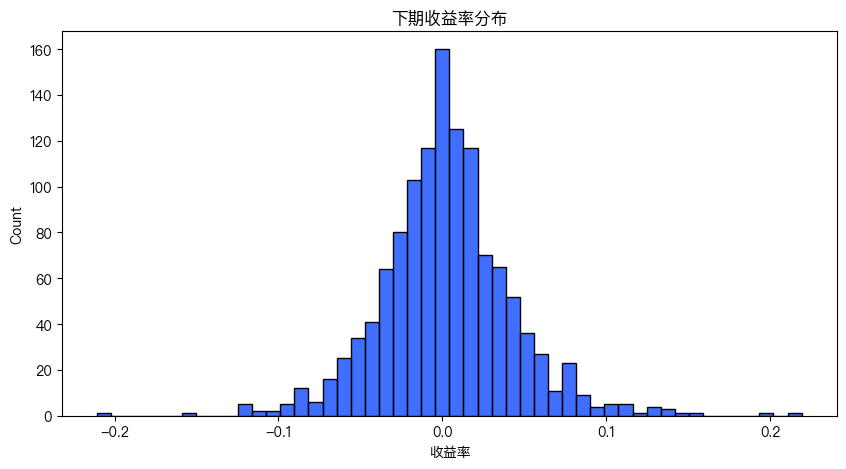

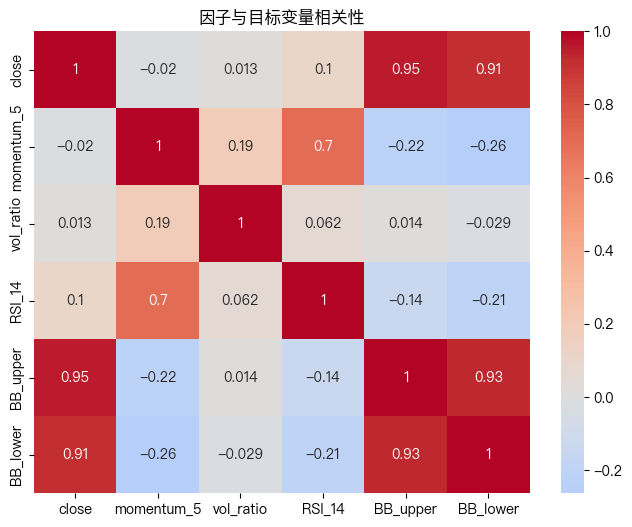

目标变量的均值=0.0022512106832757645
目标变量的方差=0.039952436916353626


In [8]:
# 计算下期收益率
df['future_ret_1d'] = df['close'].pct_change().shift(-1)

# 去掉NaN值
df.dropna(inplace=True)

print("添加目标变量后的数据预览：")
print(df[['close']+factors].head(10))

# 绘制目标变量分布
plt.figure(figsize=(10, 5))
sns.histplot(df['future_ret_1d'], bins=50)
plt.title('下期收益率分布')
plt.xlabel('收益率')
plt.show()

# 计算因子与目标变量的相关性
corr = df[['close']+factors].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm', center=0)
plt.title('因子与目标变量相关性')
plt.show()

print(f"目标变量的均值={np.mean(df['future_ret_1d'])}")
print(f"目标变量的方差={np.std(df['future_ret_1d'])}")

## 4. 划分训练集与测试集

按照时间顺序，使用前80%的数据作为训练集，后20%作为测试集。

训练集范围: 2020-04-09 00:00:00 → 2023-03-20 00:00:00
验证集范围: 2023-03-21 00:00:00 → 2024-03-13 00:00:00
测试集范围: 2024-03-14 00:00:00 → 2025-03-10 00:00:00

训练集样本数: 741
验证集样本数: 247
测试集样本数: 247


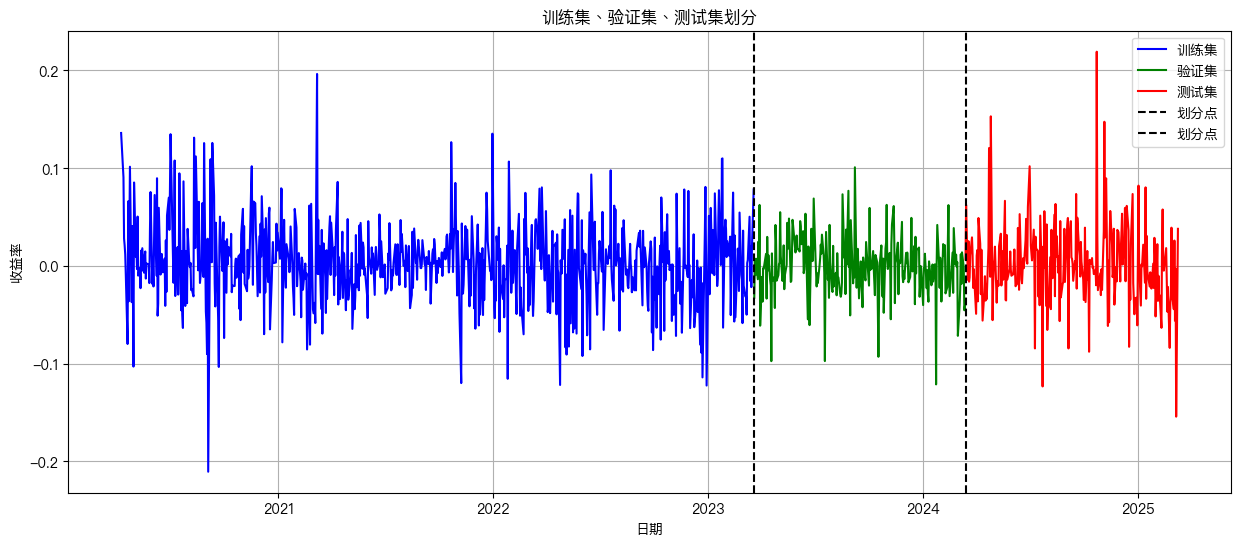

In [9]:
# 计算分割点
train_idx = int(len(df) * 0.6)
valid_idx = int(len(df) * 0.8)

split_date_1 = df.index[train_idx]
split_date_2 = df.index[valid_idx]

train_data = df.iloc[:train_idx].copy()
valid_data = df.iloc[train_idx:valid_idx].copy()
test_data = df.iloc[valid_idx:].copy()

print("训练集范围:", train_data.index.min(), "→", train_data.index.max())
print("验证集范围:", valid_data.index.min(), "→", valid_data.index.max())
print("测试集范围:", test_data.index.min(), "→", test_data.index.max())
print("\n训练集样本数:", len(train_data))
print("验证集样本数:", len(valid_data))
print("测试集样本数:", len(test_data))

# 可视化训练集和测试集的划分
plt.figure(figsize=(15, 6))
plt.plot(train_data.index, train_data['future_ret_1d'], label='训练集', color='blue')
plt.plot(valid_data.index, valid_data['future_ret_1d'], label='验证集', color='green')
plt.plot(test_data.index, test_data['future_ret_1d'], label='测试集', color='red')
plt.axvline(split_date_1, color='black', linestyle='--', label='划分点')
plt.axvline(split_date_2, color='black', linestyle='--', label='划分点')
plt.title('训练集、验证集、测试集划分')
plt.xlabel('日期')
plt.ylabel('收益率')
plt.legend()
plt.grid(True)
plt.show()

## 5. Buy&Hold 策略

In [10]:
# 若想看最优参数的详细回测日志，可再手动调用:
bh_result, bh_cerebro = run_backtest(
    ticker=ticker,
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=BuyAndHoldStrategy,
    initial_cash=100000,
    print_log=True,  # 这次打开日志
    timeframe=bt.TimeFrame.Days,
    compression=1
)

初始资金: 100000.00
2024-03-14 00:00:00 [买入] 执行买入并持有策略: 价格=162.50, 数量=584
2024-03-15 00:00:00 [成交] 买单执行: 价格=163.21, 数量=584
2025-03-10 00:00:00 [回测结束] Buy & Hold 策略最终市值: 134325.64
2025-03-10 00:00:00 [回测结束] 总收益率: 34.33%
回测结束资金: 134325.64
=== 回测分析报告 ===
夏普比率: 0.7685
最大回撤比例: 52.84%
最大回撤金额(自定义): 150502.64
累计收益率: 29.51%
年化收益率: 35.13%
=== 交易详情 ===
总交易笔数: 1
胜率: 0 / 1


In [11]:

# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型
if not hasattr(np, 'object'):
    np.object = object  # 兼容 backtrader_plotting 的引用

/var/folders/lb/hgfyjd8d6jdgjkfcksmwvbd80000gq/T/ipykernel_21644/1425693070.py:5: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, 'object'):


In [12]:
plot_results(bh_cerebro)

Loading BokehJS ...

## 6. 训练MLP

In [13]:
features = factors
X_train = train_data[features].values
y_train = train_data['future_ret_1d'].values
X_valid = valid_data[features].values
y_valid = valid_data['future_ret_1d'].values
X_test = test_data[features].values
y_test = test_data['future_ret_1d'].values

In [14]:
import copy
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid
from sklearn.pipeline import Pipeline

# 假设 X_train, y_train, X_valid, y_valid, X_test, y_test 已经定义

######################################
# 1. 建立 Pipeline（先缩放，再 MLP 回归）
######################################
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('mlp', MLPRegressor(random_state=42, max_iter=1000))
])

######################################
# 2. 定义 MLP 的超参数搜索范围
######################################
param_grid_mlp = {
    'mlp__hidden_layer_sizes': [(64, 64), (128, 128), (256, 256)],
    'mlp__alpha': [1e-4, 1e-3, 1e-2],
    'mlp__learning_rate_init': [1e-3, 1e-2],
    'mlp__solver': ['adam', 'sgd']
}

######################################
# 3. 遍历所有参数组合，寻找最优 MLP 模型（在验证集上评估）
######################################
best_score = float('-inf')
best_params = None
best_pipeline = None

for params in ParameterGrid(param_grid_mlp):
    # 设置 Pipeline 的参数
    pipeline.set_params(**params)
    pipeline.fit(X_train, y_train)
    
    # 在验证集上进行预测和评估
    valid_pred = pipeline.predict(X_valid)
    valid_r2 = r2_score(y_valid, valid_pred)
    
    if valid_r2 > best_score:
        best_score = valid_r2
        best_params = params
        # 复制当前 pipeline，保存最佳模型
        best_pipeline = copy.deepcopy(pipeline)
        print('updated', best_score, best_params)

print("Best Params:", best_params)

######################################
# 4. 使用最优模型在训练集和测试集上评估
######################################
y_pred_train_mlp = best_pipeline.predict(X_train)
y_pred_test_mlp  = best_pipeline.predict(X_test)

train_mse_mlp = mean_squared_error(y_train, y_pred_train_mlp)
test_mse_mlp  = mean_squared_error(y_test, y_pred_test_mlp)
train_r2_mlp  = r2_score(y_train, y_pred_train_mlp)
test_r2_mlp   = r2_score(y_test, y_pred_test_mlp)

print("==== MLP - 训练集 ====")
print("MSE:", train_mse_mlp)
print("R2: ", train_r2_mlp)

print("==== MLP - 测试集 ====")
print("MSE:", test_mse_mlp)
print("R2: ", test_r2_mlp)

updated -0.4151653557031676 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.001, 'mlp__solver': 'adam'}
updated -0.1506631889886274 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (64, 64), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated -0.05583089717663259 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (128, 128), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated 0.009406988576607156 {'mlp__alpha': 0.0001, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
updated 0.012027576448328303 {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
Best Params: {'mlp__alpha': 0.01, 'mlp__hidden_layer_sizes': (256, 256), 'mlp__learning_rate_init': 0.01, 'mlp__solver': 'adam'}
==== MLP - 训练集 ====
MSE: 0.0016249659482098556
R2:  0.07700573172005343
==== MLP - 测试集 ====
MSE: 0.001765236087664075
R2:  0.010958584235108426

In [15]:
train_data

,close,high,low,open,volume,momentum_5,vol_ratio,RSI_14,BB_upper,BB_middle,BB_lower,future_ret_1d
Date,,,,,,,,,,,,
2020-04-09,38.2000,38.3453,37.1407,37.4727,204750000,0.2608,0.0272,54.1876,39.7858,32.6168,25.4478,0.1360
2020-04-13,43.3967,43.4667,38.7020,39.3440,337131000,0.3561,-0.0236,61.5239,41.4042,32.9646,24.5249,0.0905
2020-04-14,47.3260,49.4587,46.1620,46.5980,458647500,0.3751,0.0475,65.9624,44.2006,33.8473,23.4940,0.0281
2020-04-15,48.6553,50.2087,47.3333,49.4667,353655000,0.3380,0.0749,67.3352,46.7505,34.8461,22.9416,0.0211
2020-04-16,49.6807,50.6300,47.1147,47.7960,309868500,0.3578,0.1159,68.3941,48.6161,36.1260,23.6360,0.0116
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-03-14,183.2600,183.8000,177.1400,177.3100,143717900,-0.0237,0.0352,48.3179,219.6131,195.1720,170.7309,-0.0153
2023-03-15,180.4500,182.3400,176.0300,180.8000,145995600,-0.0085,0.0349,46.6146,218.0792,193.7320,169.3848,0.0204
2023-03-16,184.1300,185.8100,178.8400,180.3700,121136800,0.0648,0.0117,49.1431,214.9871,192.2265,169.4659,-0.0217


## 6. 使用Backtrader进行回测

In [16]:
import backtrader as bt

# 自定义成交量指标，把成交量数据单独显示在子图中
class MyVolumeIndicator(bt.Indicator):
    """
    简单示例，把data的volume包装成一个单独的子图指标。
    """
    lines = ('vol',)
    plotinfo = dict(subplot=True, plotname='Volume')  # 让它单独开子图

    def __init__(self):
        self.lines.vol = self.data.volume

class MLFactorStrategy(bt.Strategy):
    params = (
        ('model', None),            # 预先训练好的机器学习模型
        ('target_percent', 0.98),   # 目标仓位百分比
    )

    def __init__(self):
        self.model = self.p.model
        
        # 关闭主图中Data自带的Volume绘制
        self.data.plotinfo.plotvolume = False

        # 自定义成交量指标以及其SMA指标
        self.myvol = MyVolumeIndicator(self.data)
        self.vol_5 = bt.indicators.SMA(self.myvol.vol, period=5)
        self.vol_5.plotinfo.subplot = True
        self.vol_10 = bt.indicators.SMA(self.myvol.vol, period=10)
        self.vol_10.plotinfo.subplot = True

        # 添加其它因子指标

        # 价格动量指标：计算5日价格百分比变化
        self.momentum_5 = bt.indicators.PercentChange(self.data.close, period=5)
        
        # RSI指标，14日周期
        self.rsi_14 = bt.indicators.RSI(self.data.close, period=14)
        
        # 布林带指标，默认20日均线和2倍标准差，返回上轨、均线和下轨
        self.bb = bt.indicators.BollingerBands(self.data.close)

        self.last_trade_type = None  # 记录上一次交易类型（buy/sell）
        
        self.value_history_dates = []
        self.value_history_values = []

    def next(self):
        # 计算各个因子的当前值
        momentum = self.momentum_5[0]
        vol_ratio = (self.vol_5[0] / self.vol_10[0] - 1) if self.vol_10[0] != 0 else 0
        rsi = self.rsi_14[0]
        bb_upper = self.bb.top[0]  # 布林带上轨
        bb_lower = self.bb.bot[0]  # 布林带下轨

        # 构建特征向量：注意顺序需要与模型训练时一致
        X = [[momentum, vol_ratio, rsi, bb_upper, bb_lower]]
        pred_ret = self.model.predict(X)[0]

        # 获取当前持仓状态
        current_position = self.getposition().size

        if pred_ret > 0 and current_position == 0:
            # 只有当当前没有仓位时，才执行买入
            self.order_target_percent(target=self.p.target_percent)
            self.last_trade_type = "BUY"
            print(f"{self.datas[0].datetime.date(0)} => BUY signal, pred_ret={pred_ret:.6f}")
        
        elif pred_ret <= 0 and current_position > 0:
            # 只有当当前有仓位时，才执行卖出
            self.order_target_percent(target=0.0)
            self.last_trade_type = "SELL"
            print(f"{self.datas[0].datetime.date(0)} => SELL signal, pred_ret={pred_ret:.6f}")

        # 只在交易执行时打印仓位信息
        if self.last_trade_type:
            print(f"Current position size: {self.getposition().size}, Value: {self.broker.getvalue()}")

        dt = self.data.datetime.date(0)
        self.value_history_dates.append(dt)
        self.value_history_values.append(self.broker.getvalue())


In [22]:
test_data

,close,high,low,open,volume,momentum_5,vol_ratio,RSI_14,BB_upper,BB_middle,BB_lower,future_ret_1d
Date,,,,,,,,,,,,
2024-03-14,162.5000,171.1700,160.5100,167.7700,126325700,-0.0904,-0.0532,27.6926,212.9732,188.5350,164.0968,0.0066
2024-03-15,163.5700,165.1800,160.7600,163.1600,96971900,-0.0671,-0.0444,29.0287,212.7655,186.6910,160.6165,0.0625
2024-03-18,173.8000,174.7200,165.9000,170.0200,108214400,-0.0223,0.0244,40.3732,211.2894,185.3835,159.4776,-0.0143
2024-03-19,171.3200,172.8200,167.4200,172.3600,77271400,-0.0350,0.0480,38.7558,210.5599,184.2615,157.9631,0.0253
2024-03-20,175.6600,176.2500,170.8200,173.0000,83846700,0.0365,0.0270,43.0550,209.3955,183.3060,157.2165,-0.0162
...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-04,272.0400,284.3500,261.8400,270.9300,126706600,-0.1016,0.1697,26.4700,404.1738,334.8230,265.4722,0.0260
2025-03-05,279.1000,279.5500,267.7100,272.9200,94042900,-0.0402,0.1253,29.9017,397.3141,329.1675,261.0209,-0.0561
2025-03-06,263.4500,272.6500,260.0200,272.0600,98451600,-0.0656,0.0620,26.9042,393.4019,323.4315,253.4611,-0.0030


In [18]:
# 若想看最优参数的详细回测日志，可再手动调用:
ml_result, ml_cerebro = run_backtest(
    ticker=ticker,
    # df=df.iloc[valid_idx:].copy(),
    df=test_data,
    start_date=start_date,
    end_date=end_date,
    strategy=MLFactorStrategy,
    initial_cash=100000,
    strategy_params={'model': best_pipeline, 'target_percent':0.98},
    print_log=True,  # 这次打开日志
)


初始资金: 100000.00
2024-04-11 => BUY signal, pred_ret=0.003732
Current position size: 0, Value: 100000.0
Current position size: 561, Value: 99151.55297853393
Current position size: 561, Value: 93782.77886964721
Current position size: 561, Value: 91331.21160890503
Current position size: 561, Value: 90399.94955446167
Current position size: 561, Value: 87303.22715761108
Current position size: 561, Value: 85687.55297853393
Current position size: 561, Value: 82882.55297853393
Current position size: 561, Value: 84357.97715761108
Current position size: 561, Value: 94147.43400575561
Current position size: 561, Value: 98663.47715761108
Current position size: 561, Value: 97603.1875000183
Current position size: 561, Value: 112054.55297853393
Current position size: 561, Value: 106012.58058168335
Current position size: 561, Value: 104166.89434816284
Current position size: 561, Value: 104178.10818483276
Current position size: 561, Value: 104840.0926361267
Current position size: 561, Value: 106842.85818

In [58]:

# ===== 猴子补丁：为 numpy 添加 bool8 和 object 属性 =====
import numpy as np
if not hasattr(np, 'bool8'):
    np.bool8 = np.bool_  # 使用 numpy 自带的 bool_ 类型
if not hasattr(np, 'object'):
    np.object = object  # 兼容 backtrader_plotting 的引用

In [1]:
plot_results(ml_cerebro)

NameError: name 'plot_results' is not defined

# 比较策略和Buy&Hold

In [60]:
results = ml_cerebro.run()  # cerebro.run() 返回一个列表，每个元素是一个策略实例
ml_strategy_instance = results[0]  # 如果你只有一个策略，就取第一个

results = bh_cerebro.run()
bh_strategy_instance = results[0]

2024-04-11 => BUY signal, pred_ret=0.003732
Current position size: 0, Value: 100000.0
Current position size: 561, Value: 99151.55297853393
Current position size: 561, Value: 93782.77886964721
Current position size: 561, Value: 91331.21160890503
Current position size: 561, Value: 90399.94955446167
Current position size: 561, Value: 87303.22715761108
Current position size: 561, Value: 85687.55297853393
Current position size: 561, Value: 82882.55297853393
Current position size: 561, Value: 84357.97715761108
Current position size: 561, Value: 94147.43400575561
Current position size: 561, Value: 98663.47715761108
Current position size: 561, Value: 97603.1875000183
Current position size: 561, Value: 112054.55297853393
Current position size: 561, Value: 106012.58058168335
Current position size: 561, Value: 104166.89434816284
Current position size: 561, Value: 104178.10818483276
Current position size: 561, Value: 104840.0926361267
Current position size: 561, Value: 106842.85818483276
Current p

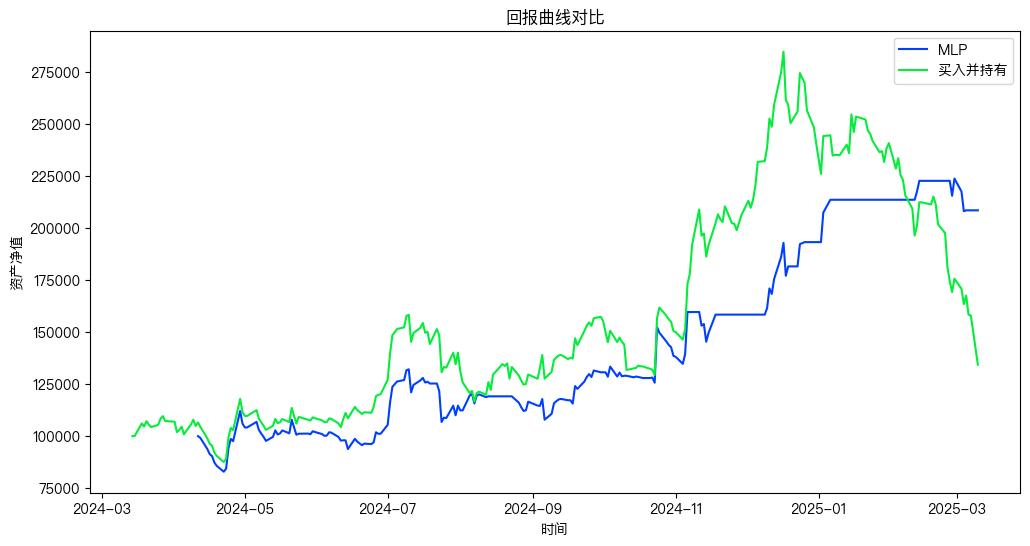

In [61]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(ml_strategy_instance.value_history_dates, ml_strategy_instance.value_history_values, label='MLP')
plt.plot(bh_strategy_instance.value_history_dates, bh_strategy_instance.value_history_values, label='买入并持有')
plt.xlabel('时间')
plt.ylabel('资产净值')
plt.title('回报曲线对比')
plt.legend()
plt.show()
